## Day 24 Lecture 2 Assignment

In this assignment, we will build our a more complex logistic regression model, this time on both numeric and categorical data. We will use the Chicago traffic crashes dataset loaded below and analyze the model generated for this dataset.

In [ ]:
%load_ext nb_black

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

%matplotlib inline

In [2]:
crash_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')

In [3]:
crash_data.head()

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN
0,JC334993,7/4/2019 22:33,45,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JC370822,7/30/2019 10:22,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN (NOT RAISED),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JC387098,8/10/2019 17:00,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,ONE-WAY,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JC395195,8/16/2019 16:53,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,...,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,JC396604,8/17/2019 16:04,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,PARKING LOT,NaN,...,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0


First, create a binary response column by modifying the "DAMAGE" column. Consider "OVER \$1500" to be the positive class, and under \$1500 to be the negative class.

In [4]:
crash_data['label'] = crash_data['DAMAGE'] == 'OVER $1,500'
crash_data['label'] = crash_data['label'].astype(int)

crash_data['label'].value_counts(normalize=True)

1    0.563418
0    0.436582
Name: label, dtype: float64

Using the code from Day 21, Lecture 1 as a starting point, devise an appropriate way to address missing values. You have a lot of freedom here; we will proceed by taking the following steps:

- Dropping all columns with more than 5% missing data
- Imputing the median for numeric columns with less than 5% missing data (except for STREET_NO; imputing it in this manner would not make any sense)
- Dropping rows with missing data for categorical columns that have less than 5% missing data

In [5]:
keep_cols = crash_data.isna().mean() <= 0.05
crash_sub = crash_data.loc[:, keep_cols]

# Rather than imputing, dropping is fairly low impact in terms
# of percent of observations dropped.  Rather than making up data
# the decision to drop was made.
og_nrows = crash_sub.shape[0]
crash_sub = crash_sub.dropna()
new_nrows = crash_sub.shape[0]

print(f'nrows pre drop {og_nrows}')
print(f'nrows post drop {new_nrows}')
print(f'percent rows dropped {100 * (og_nrows - new_nrows) / og_nrows:.2f}%')

crash_sub.head()

nrows pre drop 372585
nrows post drop 362480
percent rows dropped 2.71%


,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,label
6,JC413474,8/30/2019 14:20,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,2.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1
7,JC414382,8/31/2019 4:35,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,"CURVE, LEVEL",...,1.0,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
8,JC413930,8/30/2019 18:30,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,...,2.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0
9,JC415166,8/31/2019 18:50,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,2.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1
10,JC415064,8/31/2019 13:15,30,TRAFFIC SIGNAL,UNKNOWN,CLOUDY/OVERCAST,DAYLIGHT,SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,2.0,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1


Finally, choose a few numeric and categorical features (2-3 of each) to include in the model. (You can definitely include more than this, but too many features, especially categorical ones, will most likely lead to convergence issues). One hot encode the chosen categorical features, being sure to omit one of the categories (which will serve as a "reference" level) to avoid perfect multicollinearity.

Again, you have a lot of freedom here; we will proceed with the following features, dropping the most commonly occurring category for the two categorical variables ("CLEAR" for weather, "REAR END" for first crash type):
POSTED_SPEED_LIMIT, WEATHER_CONDITION, INJURIES_TOTAL, FIRST_CRASH_TYPE

In [6]:
keep_cols = ['label', 'POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'INJURIES_TOTAL', 'FIRST_CRASH_TYPE']
crash_sub = crash_sub[keep_cols]
crash_sub.head()

,label,POSTED_SPEED_LIMIT,WEATHER_CONDITION,INJURIES_TOTAL,FIRST_CRASH_TYPE
6,1,30,CLEAR,0.0,REAR END
7,1,30,CLEAR,1.0,FIXED OBJECT
8,0,30,CLEAR,0.0,TURNING
9,1,30,CLEAR,0.0,PARKED MOTOR VEHICLE
10,1,30,CLOUDY/OVERCAST,1.0,SIDESWIPE SAME DIRECTION


In [7]:
# In practice, use OneHotEncoder. For today, we'll use pd.get_dummies()
drop_cats = ['WEATHER_CONDITION_CLEAR', 'FIRST_CRASH_TYPE_REAR END']
crash_sub_dummy = pd.get_dummies(crash_sub)
crash_sub_dummy = crash_sub_dummy.drop(columns=drop_cats)
crash_sub_dummy.head()

# This is an example of multicollinearity (think farenheit and celsius columns)
# Thats why we'll drop one dummy col when modeling.

# farenheit = 9/5 * celsius + 32
#
# 1 - (is_a + is_b) = is_c
# 1 - (1 + 0) = 0
# 1 - (0 + 1) = 0
# 1 - (0 + 0) = 1
#
# cat_col   is_a  is_b  is_c
# 'a'        1      0     0
# 'b'   ->   0      1     0
# 'c'        0      0     1

,label,POSTED_SPEED_LIMIT,INJURIES_TOTAL,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,...,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING
6,1,30,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,30,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,30,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,1,30,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10,1,30,1.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Split the data into train and test, with 80% training and 20% testing.

In [8]:
X = crash_sub_dummy.drop(columns=['label'])
y = crash_sub_dummy['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Fit the logistic regression model using the sklearn package and print out the coefficient summary. Which variables (in particular, which categories of our categorical variables) appear to be the most important, and what effect do they have on the probability of a crash resulting in $1500 or more in damages?

In [9]:
model = LogisticRegression(max_iter=250)
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'train score {100 * train_score:.2f}%')
print(f'test score {100 * test_score:.2f}%')

/Users/wyattgarner/data_science-env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train score 58.36%
test score 58.35%


In [10]:
model.n_iter_

array([250], dtype=int32)

In [11]:
coef_df = pd.DataFrame()
coef_df['feat'] = X_train.columns
coef_df['coef'] = model.coef_[0]
coef_df['abs_coef'] = coef_df['coef'].abs()

coef_df = coef_df.sort_values('abs_coef', ascending=False)

print('Most influential WEATHER features')
display(coef_df.loc[coef_df['feat'].str.startswith('WEATHER'), ['feat', 'coef']].head())

print('\n\n\nMost influential FIRST_CRASH_TYPE features')
display(coef_df.loc[coef_df['feat'].str.startswith('FIRST_CRASH_TYPE'), ['feat', 'coef']].head())

Most influential WEATHER features


,feat,coef
5,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,0.391570
4,WEATHER_CONDITION_FOG/SMOKE/HAZE,0.305005
9,WEATHER_CONDITION_SLEET/HAIL,0.293565
6,WEATHER_CONDITION_OTHER,0.263805
8,WEATHER_CONDITION_SEVERE CROSS WIND GATE,0.239570





Most influential FIRST_CRASH_TYPE features


,feat,coef
20,FIRST_CRASH_TYPE_PEDALCYCLIST,-1.810793
21,FIRST_CRASH_TYPE_PEDESTRIAN,-1.743904
18,FIRST_CRASH_TYPE_OVERTURNED,1.038509
14,FIRST_CRASH_TYPE_FIXED OBJECT,0.745118
12,FIRST_CRASH_TYPE_ANGLE,0.682580


As we did on the previous exercise, make predictions on the test set and join them to the corresponding true outcomes, then use the *calibration_curve* function in scikit learn to plot a calibration curve. Nah

Is the model well-calibrated? Nah

In [12]:
pred_df = X_test.copy()
pred_df['actual'] = y_test
pred_df['predicted'] = model.predict(X_test)

y_true = pred_df['actual']
y_pred = pred_df['predicted']

confusion_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

confusion_df = pd.DataFrame(
    confusion_mat,
    # columns=["predicted_0", "predicted_1"],
    columns=["predicted_not_over_1500", "predicted_over_1500"],
    # index=["actual_0", "actual_1"],
    index=["actual_not_over_1500", "actual_over_1500"],
)
confusion_df

,predicted_not_over_1500,predicted_over_1500
actual_not_over_1500,9443,22317
actual_over_1500,7875,32861


In [13]:
calibration_curve(pred_df['actual'], pred_df['predicted'])

(array([0.45472918, 0.59554533]), array([0., 1.]))

In [14]:
# Using the confusion matrix
print(7867 / (9433 + 7867))      # For actual class 0; probability of predicting a 1 is...
print(32869 / (22327 + 32869))   # For actual class 1; probability of predicting a 1 is...

0.45473988439306356
0.5954960504384376


In [15]:
from sklearn.metrics import classification_report, auc, roc_curve

report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.55      0.30      0.38     31760
           1       0.60      0.81      0.69     40736

    accuracy                           0.58     72496
   macro avg       0.57      0.55      0.54     72496
weighted avg       0.57      0.58      0.55     72496



In [16]:
n_actual_0 = 9404 + 22356
n_actual_1 = 7914 + 32822

print(n_actual_0)
print(n_actual_1)

31760
40736


In [17]:
y_test.value_counts(normalize=True)

1    0.561907
0    0.438093
Name: label, dtype: float64

In [18]:
fpr, tpr, thresholds = roc_curve(y_true, model.predict_proba(X_test)[:, 1])

In [19]:
roc_curve?

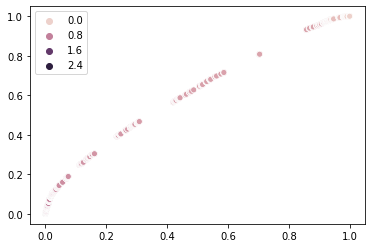

In [20]:
import seaborn as sns

sns.scatterplot(fpr, tpr, hue=thresholds)
